# Lendo os Dados

In [1]:
# yelp_academic_dataset_review.json
with open ("yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
        reviews = f.readlines()
        
reviews[:3]

['{"votes": {"funny": 0, "useful": 2, "cool": 1}, "user_id": "Xqd0DzHaiyRqVH3WRG7hzg", "review_id": "15SdjuK7DmYqUAj6rjGowg", "stars": 5, "date": "2007-05-17", "text": "dr. goldberg offers everything i look for in a general practitioner.  he\'s nice and easy to talk to without being patronizing; he\'s always on time in seeing his patients; he\'s affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i\'m sitting here trying to think of any complaints i have about him, but i\'m really drawing a blank.", "type": "review", "business_id": "vcNAWiLM4dR7D2nwwJ7nCA"}\n',
 '{"votes": {"funny": 0, "useful": 2, "cool": 0}, "user_id": "H1kH6QZV7Le4zqTRNxoZow", "review_id": "RF6UnRTtG7tWMcrO2GEoAg", "stars": 2, "date": "2010-03-22", "text": "Unfortunately, the frustration of being Dr. Goldberg\'s p

In [2]:
print("São %d reviews."%len(reviews))

São 1125458 reviews.


In [2]:
import json

reviews = [json.loads(review.strip()) for review in reviews]

In [3]:
reviews[0]

{'votes': {'funny': 0, 'useful': 2, 'cool': 1},
 'user_id': 'Xqd0DzHaiyRqVH3WRG7hzg',
 'review_id': '15SdjuK7DmYqUAj6rjGowg',
 'stars': 5,
 'date': '2007-05-17',
 'text': "dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.",
 'type': 'review',
 'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA'}

In [4]:
reviews[34578]

{'votes': {'funny': 0, 'useful': 0, 'cool': 0},
 'user_id': 'TLweDQj83Wgjy-6LaQO_Eg',
 'review_id': 'BstZDMW7K81Rf0w1yzEl2Q',
 'stars': 5,
 'date': '2013-09-08',
 'text': 'One of the best pedicures I have ever had! My nails are beautiful, really appreciated that Don made a suggestion and showed me what it would look like before putting on my nails. Only slight irritation was that I made appointment but I still waited 30 minutes. Because everything was great, I am able to over look that.',
 'type': 'review',
 'business_id': 'TDKSqI2O4nf5DNKoHn-MoA'}

# Preparando os dados para aplicar LDA

Ver notebook [Samba e a Alocação Latente de Dirichlet (LDA](https://www.kaggle.com/clovesgtx/samba-e-a-aloca-o-latente-de-dirichlet-lda)

In [5]:
import numpy as np
import pandas as pd
import re, nltk, gensim
import requests
import json
from sklearn.externals import joblib

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

/home/cloves/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [6]:
text_reviews = [review["text"] for review in reviews]

In [7]:
# Tokenização dos docs
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(text_reviews))

print(data_words[:1])

[['dr', 'goldberg', 'offers', 'everything', 'look', 'for', 'in', 'general', 'practitioner', 'he', 'nice', 'and', 'easy', 'to', 'talk', 'to', 'without', 'being', 'patronizing', 'he', 'always', 'on', 'time', 'in', 'seeing', 'his', 'patients', 'he', 'affiliated', 'with', 'top', 'notch', 'hospital', 'nyu', 'which', 'my', 'parents', 'have', 'explained', 'to', 'me', 'is', 'very', 'important', 'in', 'case', 'something', 'happens', 'and', 'you', 'need', 'surgery', 'and', 'you', 'can', 'get', 'referrals', 'to', 'see', 'specialists', 'without', 'having', 'to', 'see', 'him', 'first', 'really', 'what', 'more', 'do', 'you', 'need', 'sitting', 'here', 'trying', 'to', 'think', 'of', 'any', 'complaints', 'have', 'about', 'him', 'but', 'really', 'drawing', 'blank']]


In [8]:
del reviews
del text_reviews

In [9]:
# Removendo Stopwords
def removeStops(texts, stopwords):
    texts_out = []
    for sent in texts:
        texts_out.append(" ".join([token for token in sent if token not in stopwords]))
    return texts_out


stopwords = nltk.corpus.stopwords.words('english')
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_without_stops = removeStops(data_words, stopwords)

# sem stopwords
print(data_without_stops[:2])

['dr goldberg offers everything look general practitioner nice easy talk without patronizing always time seeing patients affiliated top notch hospital nyu parents explained important case something happens need surgery get referrals see specialists without see first really need sitting trying think complaints really drawing blank', 'unfortunately frustration dr goldberg patient repeat experience many doctors nyc good doctor terrible staff seems staff simply never answers phone usually takes hours repeated calling get answer time wants deal run problem many doctors get office workers patients medical needs anyone answering phone work aggravation regret feel give dr goldberg stars']


In [10]:
del data_words

### Criando a matriz Documento-Palavra

In [11]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=30,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                            )

# data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_vectorized = vectorizer.fit_transform(data_without_stops)

# Treinando o Modelo LDA com Sklearn

In [12]:
# Define Search Param
search_params = {'n_components': [10, 20, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [14]:
from joblib import dump, load

dump(model, 'topicModel.joblib')

['topicModel.joblib']

In [16]:
dump(best_lda_model, "best_lda_model.joblib")

['best_lda_model.joblib']

In [13]:
# Melhor modelo
best_lda_model = model.best_estimator_

# Hiperparâmetros do modelo
print("Melhores parâmetros: ", model.best_params_)

# probabilidade logarítmica
print("Melhor score de probabilidade logarítmica: ", model.best_score_)

# Perplexidade
print("Perplexidade do modelo: ", best_lda_model.perplexity(data_vectorized))


Melhores parâmetros:  {'learning_decay': 0.7, 'n_components': 20}
Melhor score de probabilidade logarítmica:  -107918309.6867714
Perplexidade do modelo:  2113.188085865173


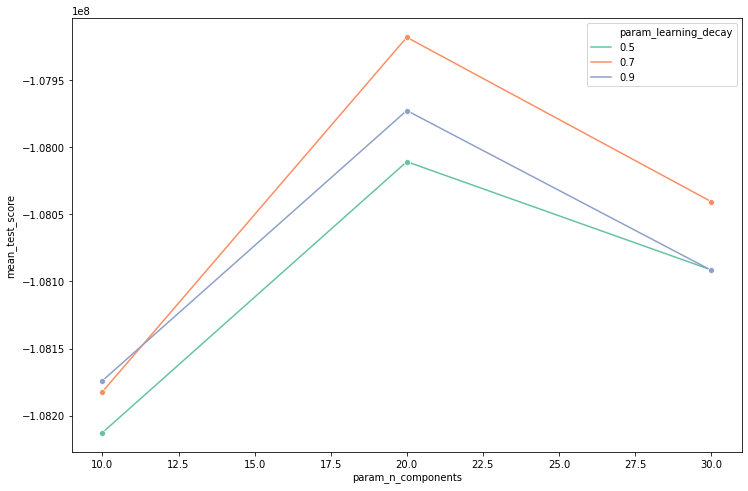

In [15]:
results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o'
            )

plt.show()